---

# <center><span style="color:red"> Practica 2: Análisis de extremos, análisis espectral y filtros</center></span>

---

In [104]:
# módulos necesarios
# modulos propios de python
import math
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')


# módulos de lectura y tratamiento de datos
import pandas  as pd
import numpy   as np
import netCDF4 as nc
import xarray  as xr

# estadistica
from scipy import stats
from scipy import special
from scipy import signal
from scipy.fft import fft
from statsmodels.tsa import stattools 

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

# librerias de visualización de datos
import matplotlib.pyplot as plt
import seaborn           as sns
import cartopy.crs       as ccrs

sns.set_style('whitegrid')

## <span style="color:green"> Objetivo 1: Análisis de Extremos </span>

<span style='color:black'>En esta primera parte de la práctica 2 se pretende analizar algunos índices de extremos de temperatura o precipitación en las regiones definidas empleando bases de datos de temperatura o precipitacion.
</span>

In [105]:
# carpeta donde tengo los datos
folder = 'data/'

# abro y leo datos de mínima temperatura diaria
temp_min = xr.open_dataset(f'{folder}tmin_pen.nc')
temp_max = xr.open_dataset(f'{folder}tmax_pen.nc')



In [125]:
# acoto los datos a las latitudes y longitudes correspondientes al norte
lats  = [43.8, 42.5]
longs = [-6.0, 0.0]

# selecciono los datos con los que voy a tratar
temp_min = temp_min.sel(lat=slice(lats[0], lats[1]), lon=slice(longs[0], longs[1]))
temp_max = temp_max.sel(lat=slice(lats[0], lats[1]), lon=slice(longs[0], longs[1]))

# separamos los datos en dos periodos
temp_min_1 = temp_min.sel(Time=slice('1973', '1994'))
temp_max_1 = temp_max.sel(Time=slice('1973', '1994'))

temp_min_2 = temp_min.sel(Time=slice('1995', '2015'))
temp_max_2 = temp_max.sel(Time=slice('1995', '2015'))


### <span style="color:darkblue"> Cold Nights </span>

In [4]:
# cold nights
# calculo de 10th percentile para mi región
qt_dims = ("Time")
qt_values = (0.1)

# calculo de los cuantiles para cada subset
ds_qt_1 = temp_min_1.quantile(qt_values, dim=qt_dims)
ds_qt_2 = temp_min_2.quantile(qt_values, dim=qt_dims)

# calculo cual va a ser el valor del quantil sup y inferior
minimo = np.min((ds_qt_1.min().tn, ds_qt_2.min().tn))
maximo = np.max((ds_qt_1.max().tn, ds_qt_2.max().tn))

In [5]:
# para el primer periodo calculo del porcentaje de noches frías
num_cold_1 = np.sum(np.where(temp_min_1.tn < ds_qt_1.to_array() , 1, 0),axis=0)

n = temp_min_1.tn.shape[0]
perc_1 = num_cold_1*100/n
# elimino la dimension 1
perc_1 = np.squeeze(perc_1)

In [6]:
# para el segundo periodo calculo del porcentaje de noches frías
num_cold_2 = np.sum(np.where(temp_min_2.tn < ds_qt_1.to_array() , 1, 0),axis=0)

n = temp_min_2.tn.shape[0]
perc_2 = num_cold_2*100/n
# elimino la dimension 1
perc_2 = np.squeeze(perc_2)

# para hacer el grafico
mini = np.min((np.min(perc_1), np.min(perc_2)))
maxi = np.max((np.max(perc_1), np.max(perc_2)))

# latitud y longitud
lon = ds_qt_1.lon
lat = ds_qt_1.lat

Text(0.5, 0.98, 'Porcentaje de noches frías definiendo el percentil con el primer periodo')

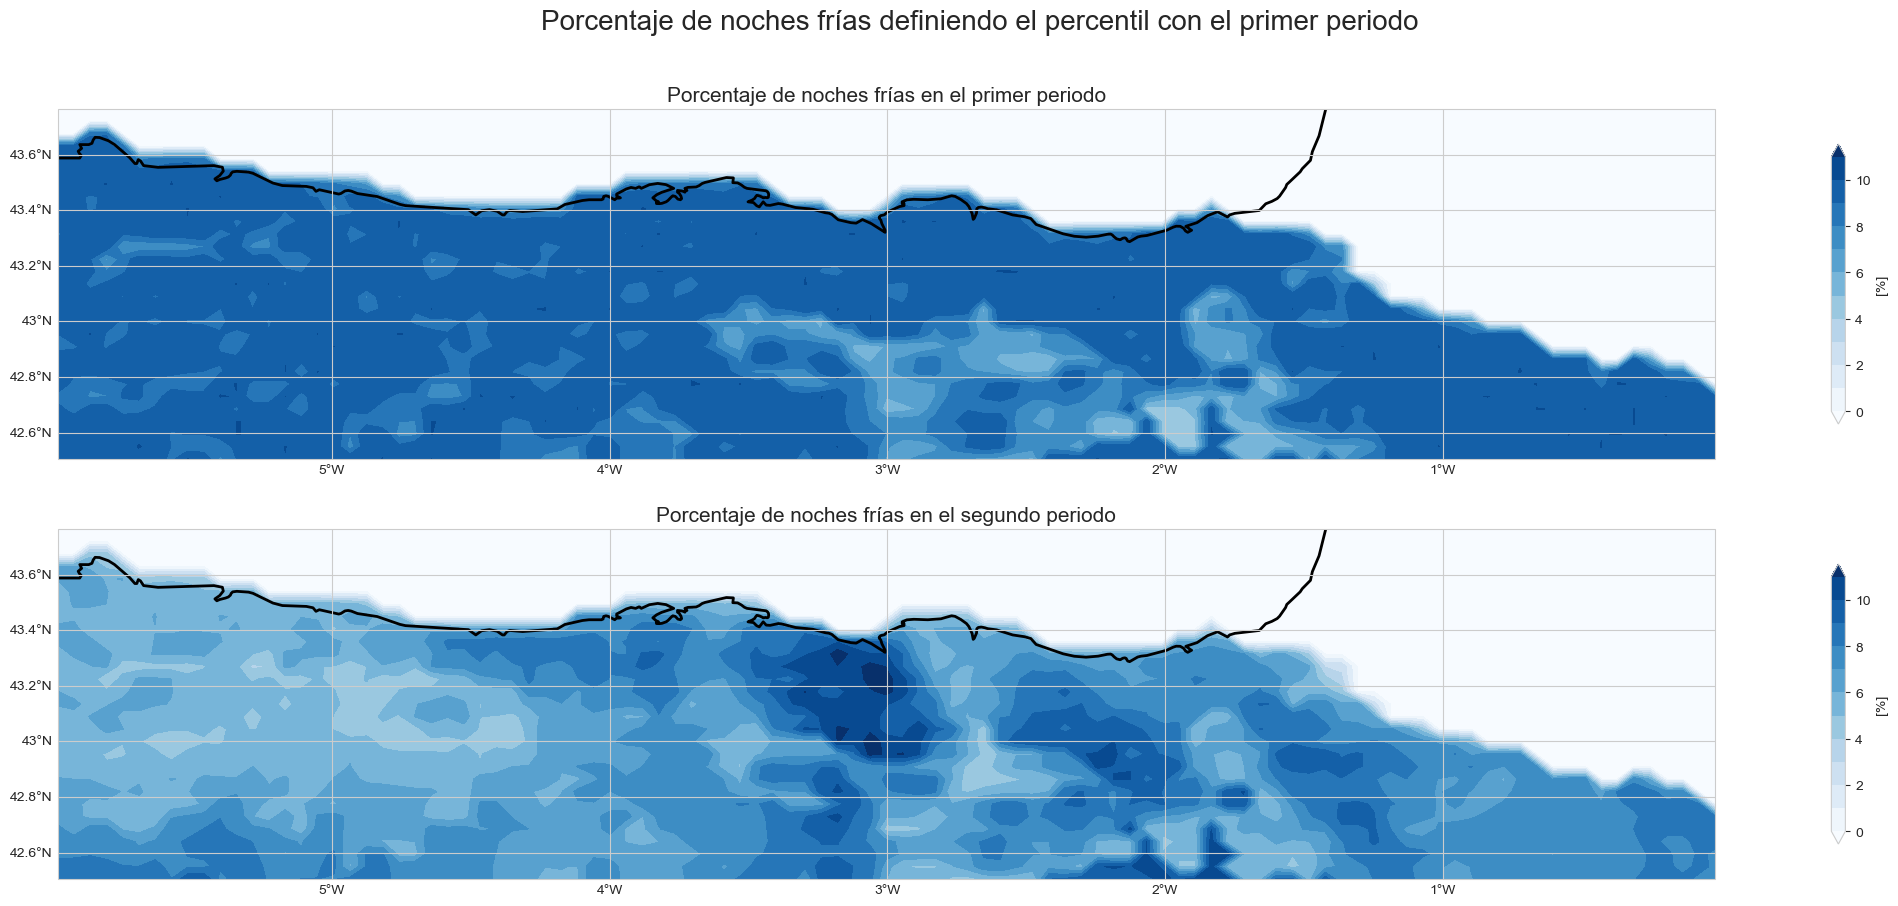

In [7]:
# Representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
cbarticks = np.arange(mini,maxi,1)

gl=ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

gl = ax2.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False
 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(lon, lat, perc_1, cbarticks,cmap = cmap, extend='both', 
                  vmin = mini, vmax = maxi)

im2 = ax2.contourf(lon, lat, perc_2, cbarticks,cmap = cmap, extend='both', 
                   vmin = mini, vmax = maxi) 
ax2.coastlines(linewidth = 2)
ax1.coastlines(linewidth = 2)
fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')
fig.colorbar(im2,ax=ax2,shrink=0.8, label=unidades,orientation='vertical')
ax1.set_title('Porcentaje de noches frías en el primer periodo',fontsize=15)
ax2.set_title('Porcentaje de noches frías en el segundo periodo',fontsize=15)
fig.suptitle('Porcentaje de noches frías definiendo el percentil con el primer periodo',
             fontsize = 20)

In [8]:
# para el primer periodo calculo del porcentaje de noches frías
num_cold_1 = np.sum(np.where(temp_min_1.tn < ds_qt_2.to_array() , 1, 0), axis=0)

n = temp_min_1.tn.shape[0]
perc_1 = num_cold_1*100/n
# elimino la dimension 1
perc_1 = np.squeeze(perc_1)


In [9]:
# para el segundo periodo calculo del porcentaje de noches frías
num_cold_2 = np.sum(np.where(temp_min_2.tn < ds_qt_2.to_array() , 1, 0),axis=0)

n = temp_min_2.tn.shape[0]
perc_2 = num_cold_2*100/n
# elimino la dimension 1
perc_2 = np.squeeze(perc_2)

# para hacer el grafico
mini = np.min((np.min(perc_1), np.min(perc_2)))
maxi = np.max((np.max(perc_1), np.max(perc_2)))

# latitud y longitud
lon = ds_qt_1.lon
lat = ds_qt_1.lat

Text(0.5, 0.98, 'Porcentaje de noches frías definiendo el percentil con el segundo periodo')

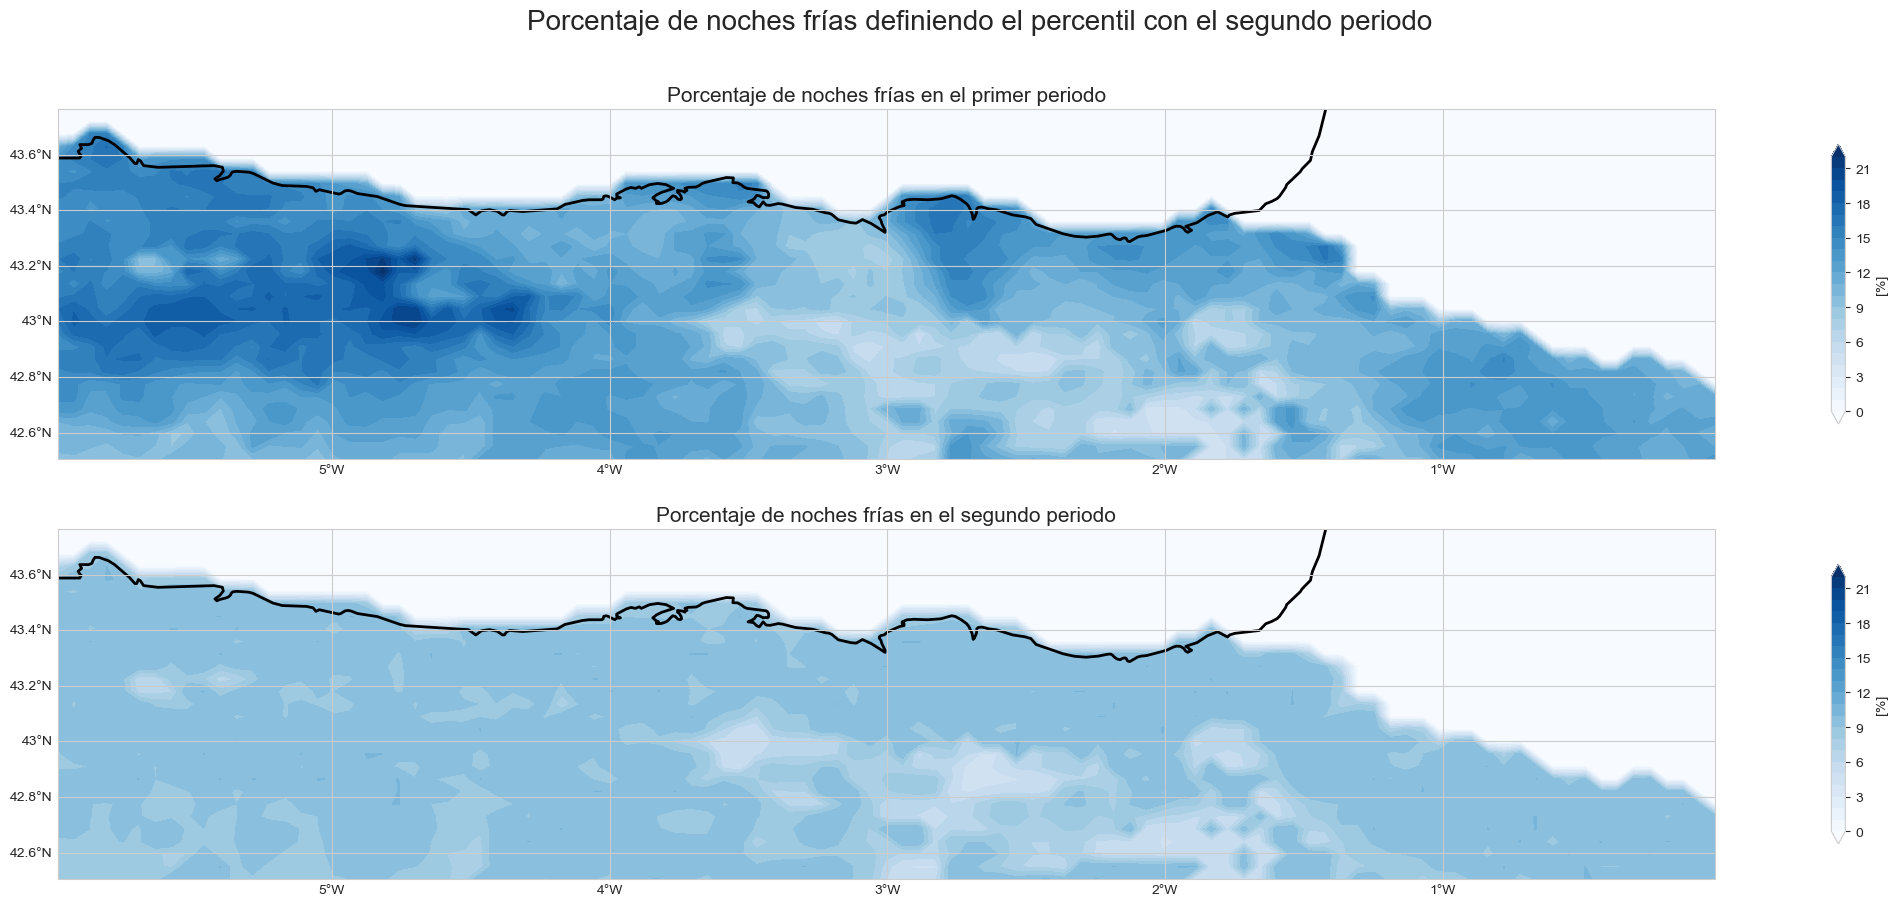

In [10]:
# Representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
cbarticks = np.arange(mini,maxi,1)


gl=ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False


gl = ax2.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(lon, lat, perc_1, cbarticks,cmap = cmap, extend='both', 
                  vmin = mini, vmax = maxi)
ax1.coastlines(linewidth = 2)

im2=ax2.contourf(lon, lat, perc_2, cbarticks,cmap = cmap, extend='both', 
                   vmin = mini, vmax = maxi)
ax2.coastlines(linewidth = 2)

fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')
fig.colorbar(im2,ax=ax2,shrink=0.8, label=unidades,orientation='vertical')
ax1.set_title('Porcentaje de noches frías en el primer periodo',fontsize=15)
ax2.set_title('Porcentaje de noches frías en el segundo periodo',fontsize=15)
fig.suptitle('Porcentaje de noches frías definiendo el percentil con el segundo periodo',
             fontsize = 20)

### <span style="color:darkblue"> Cold Days </span>

In [11]:
# cold nights
# calculo de 10th percentile para mi región
qt_dims = ("Time")
qt_values = (0.1)

# calculo de los cuantiles para cada subset
ds_qt_1 = temp_max_1.quantile(qt_values, dim=qt_dims)
ds_qt_2 = temp_max_2.quantile(qt_values, dim=qt_dims)

# calculo cual va a ser el valor del quantil sup y inferior
minimo = np.min((ds_qt_1.min().tx, ds_qt_2.min().tx))
maximo = np.max((ds_qt_1.max().tx, ds_qt_2.max().tx))

In [12]:
# para el primer periodo calculo del porcentaje de noches frías
num_cold_1 = np.sum(np.where(temp_max_1.tx < ds_qt_1.to_array() , 1, 0),axis=0)

n = temp_max_1.tx.shape[0]
perc_1 = num_cold_1*100/n
# elimino la dimension 1
perc_1 = np.squeeze(perc_1)


In [13]:
# para el segundo periodo calculo del porcentaje de noches frías
num_cold_2 = np.sum(np.where(temp_max_2.tx < ds_qt_1.to_array() , 1, 0),axis=0)

n = temp_max_2.tx.shape[0]
perc_2 = num_cold_2*100/n
# elimino la dimension 1
perc_2 = np.squeeze(perc_2)

# para hacer el grafico
mini = np.min((np.min(perc_1), np.min(perc_2)))
maxi = np.max((np.max(perc_1), np.max(perc_2)))

# latitud y longitud
lon = ds_qt_1.lon
lat = ds_qt_1.lat

Text(0.5, 0.98, 'Porcentaje de días fríos definiendo el percentil con el primer periodo')

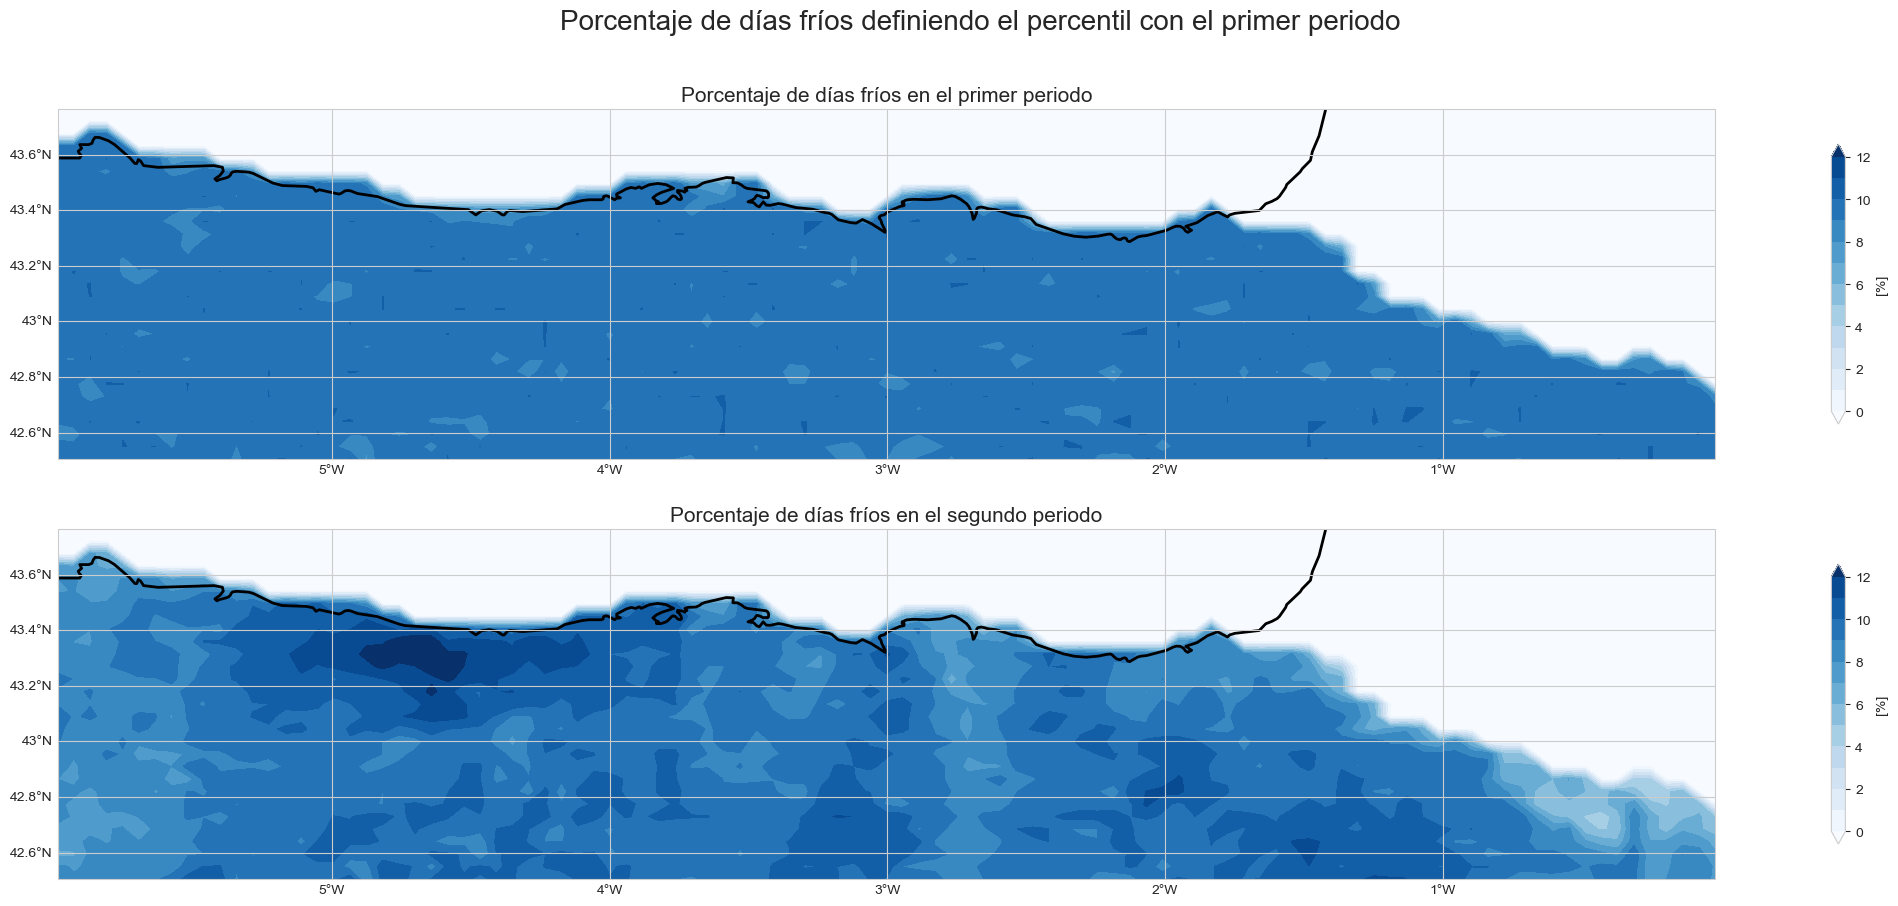

In [14]:
#Representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
cbarticks = np.arange(mini,maxi,1)

gl=ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

gl = ax2.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(lon, lat, perc_1, cbarticks,cmap = cmap, extend='both', 
                  vmin = mini, vmax = maxi)
ax1.coastlines(linewidth = 2)

im2=ax2.contourf(lon, lat, perc_2, cbarticks,cmap = cmap, extend='both', 
                   vmin = mini, vmax = maxi)
ax2.coastlines(linewidth = 2)

fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')
fig.colorbar(im2,ax=ax2,shrink=0.8, label=unidades,orientation='vertical')
ax1.set_title('Porcentaje de días fríos en el primer periodo',fontsize=15)
ax2.set_title('Porcentaje de días fríos en el segundo periodo',fontsize=15)
fig.suptitle('Porcentaje de días fríos definiendo el percentil con el primer periodo',
             fontsize = 20)

In [15]:
# para el primer periodo calculo del porcentaje de noches frías
num_cold_1 = np.sum(np.where(temp_max_1.tx < ds_qt_2.to_array() , 1, 0), axis=0)

n = temp_max_1.tx.shape[0]
perc_1 = num_cold_1*100/n
# elimino la dimension 1
perc_1 = np.squeeze(perc_1)

In [16]:
# para el segundo periodo calculo del porcentaje de noches frías
num_cold_2 = np.sum(np.where(temp_max_2.tx < ds_qt_2.to_array() , 1, 0),axis=0)

n = temp_max_2.tx.shape[0]
perc_2 = num_cold_2*100/n
# elimino la dimension 1
perc_2 = np.squeeze(perc_2)

# para hacer el grafico
mini = np.min((np.min(perc_1), np.min(perc_2)))
maxi = np.max((np.max(perc_1), np.max(perc_2)))

# latitud y longitud
lon = ds_qt_1.lon
lat = ds_qt_1.lat

Text(0.5, 0.98, 'Porcentaje de días fríos definiendo el percentil con el segundo periodo')

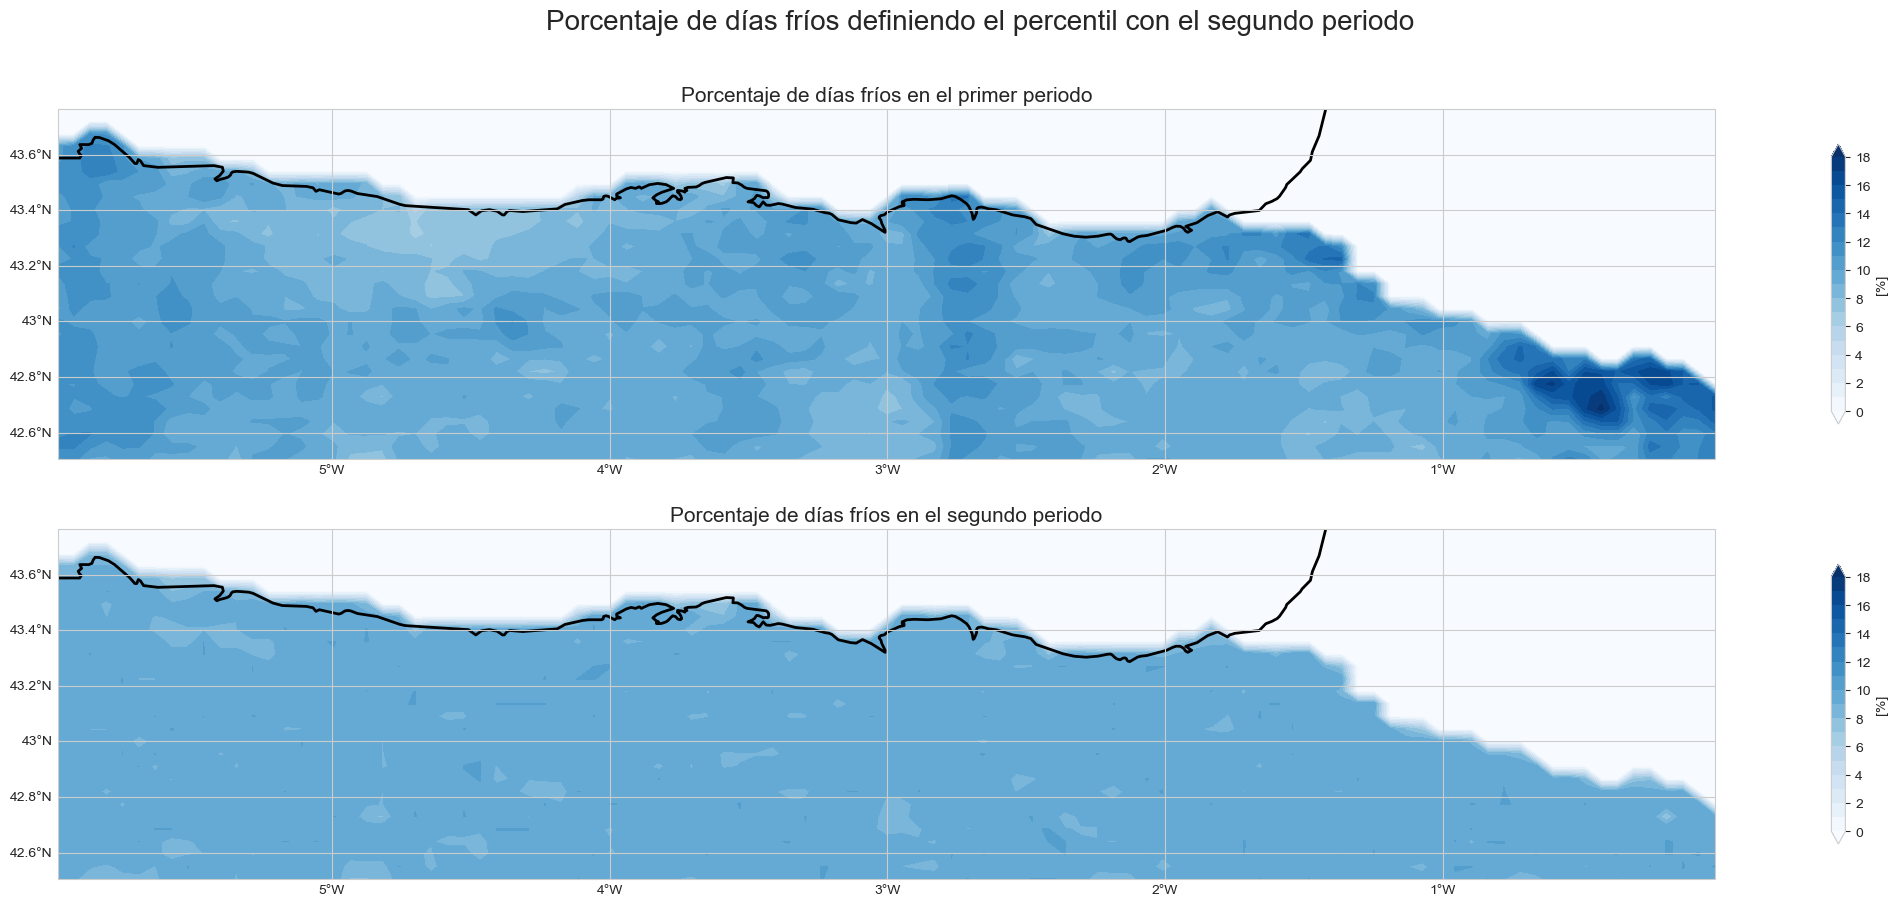

In [17]:
#Representamos el porcentaje para cada punto de la malla de datos
fig = plt.figure(figsize=(30,10), tight_layout=False) 
ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree())
cbarticks = np.arange(mini, maxi, 1)

gl=ax1.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

gl = ax2.gridlines(draw_labels = True)
gl.ylabels_right = False
gl.xlabels_top   = False

 
cmap= 'Blues'
unidades= '[%]'

im=ax1.contourf(lon, lat, perc_1, cbarticks,cmap = cmap, extend='both', 
                  vmin = mini, vmax = maxi)
ax1.coastlines(linewidth = 2)


im2=ax2.contourf(lon, lat, perc_2, cbarticks,cmap = cmap, extend='both', 
                   vmin = mini, vmax = maxi)
ax2.coastlines(linewidth = 2)

fig.colorbar(im,ax=ax1,shrink=0.8, label=unidades,orientation='vertical')
fig.colorbar(im2,ax=ax2,shrink=0.8, label=unidades,orientation='vertical')
ax1.set_title('Porcentaje de días fríos en el primer periodo',fontsize=15)
ax2.set_title('Porcentaje de días fríos en el segundo periodo',fontsize=15)
fig.suptitle('Porcentaje de días fríos definiendo el percentil con el segundo periodo',
             fontsize = 20)

### <span style="color:darkblue"> Periodo de Retorno </span>

In [18]:
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad f(z)')
    ax.set_xlabel('z')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Probability plot',fontsize=25)
    ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    xTeor = -xTeor
    xSort = -xSort
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Model')
    ax.set_xlabel('Empirical')
    ax.set_title('Quantile plot',fontsize=25)
    ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,-zp)
    ax.grid()
    ax.set_xlim(1e-1,1e3)
    ax.semilogx(1/pExp,-xSort,'o')
    ax.set_title('Return level plot',fontsize=25)
    ax.set_xlabel('Return period (years)')
    ax.set_ylabel('Return level')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-2, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostics',weight='bold',fontsize=25)
    
    return 

def diagnosticsGPD(x,c,m,s,numYears,invert=False):
    fig, ax = plt.subplots(2, 2, figsize=(20,15))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    fig.tight_layout
    return (fig,ax)

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(-x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(-x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    ax.set_title('Density plot',fontsize=25)
    return
  

def readDataFrame(stationName):
    url = 'isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1973
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/'+str(iyr)+'/'+station +'-'+ str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')
    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    dataDailyMean = data.groupby(['year','month','day']).mean().drop(['hour'],axis=1).reset_index()
    dataDailyMean['time'] = pd.to_datetime(dataDailyMean[['year','month','day']],yearfirst=True)
    dataDailyMean = dataDailyMean.set_index('time')
    return dataDailyMax

In [19]:
# Extremos por bloques
#===========================================================================================
# 1. Elegimos el tamaño de los bloques: de los datasets temp_min, temp_max
n = 1 #year

# voy a trabajar con pandas
df_min = temp_min.to_dataframe()

# deshago el multiindice
df_min.reset_index(inplace=True)

# Separo el dataset por años
df_min['year'] = df_min['Time'].dt.year

# elijo como índice la fecha
# df_min.set_index('Time', inplace=True)

# creo un lista de dataframes cada uno con datos de un año
list_df_years = [df_min[df_min['year'] == y] for y in df_min['year'].unique()]

# recuerda que los años can desde 1973 a 2015

In [20]:
# cojo el maximo de cada bloque de un año
list_of_max = [i.max()['tn'] for i in list_df_years]
len(list_of_max)

115

In [21]:
def correct_series_no(percent, tmin):

    tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),
                    lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),
                    Time=slice('1901','2015'))

    tminR_year = tminR.sel(Time=((tminR.Time.dt.month == 6) & (tminR.Time.dt.day == 1)))
    corr_R = np.where(np.isnan(tminR_year), np.nan, percent)
    tmin = np.where(np.isnan(tminR_year), np.nan, tminR_year)

    return np.nanmean(corr_R,axis=(1,2)), np.nanmean(tmin,axis=(1,2))

#### <span style='color:black'>Cold Nights</span>

In [22]:
# open data
percent_cold_nights_N = xr.open_dataarray(f'{folder}percent_cold_nights_N.nc')
temp_min              = xr.open_dataset(f'{folder}tmin_pen.nc')

temp_min_mean = temp_min.mean(dim=['lat', 'lon']).tn

MLE =126908.398
c   = -0.330
m   = 5.447
s   = 5.173
100 yr return value = 17.686


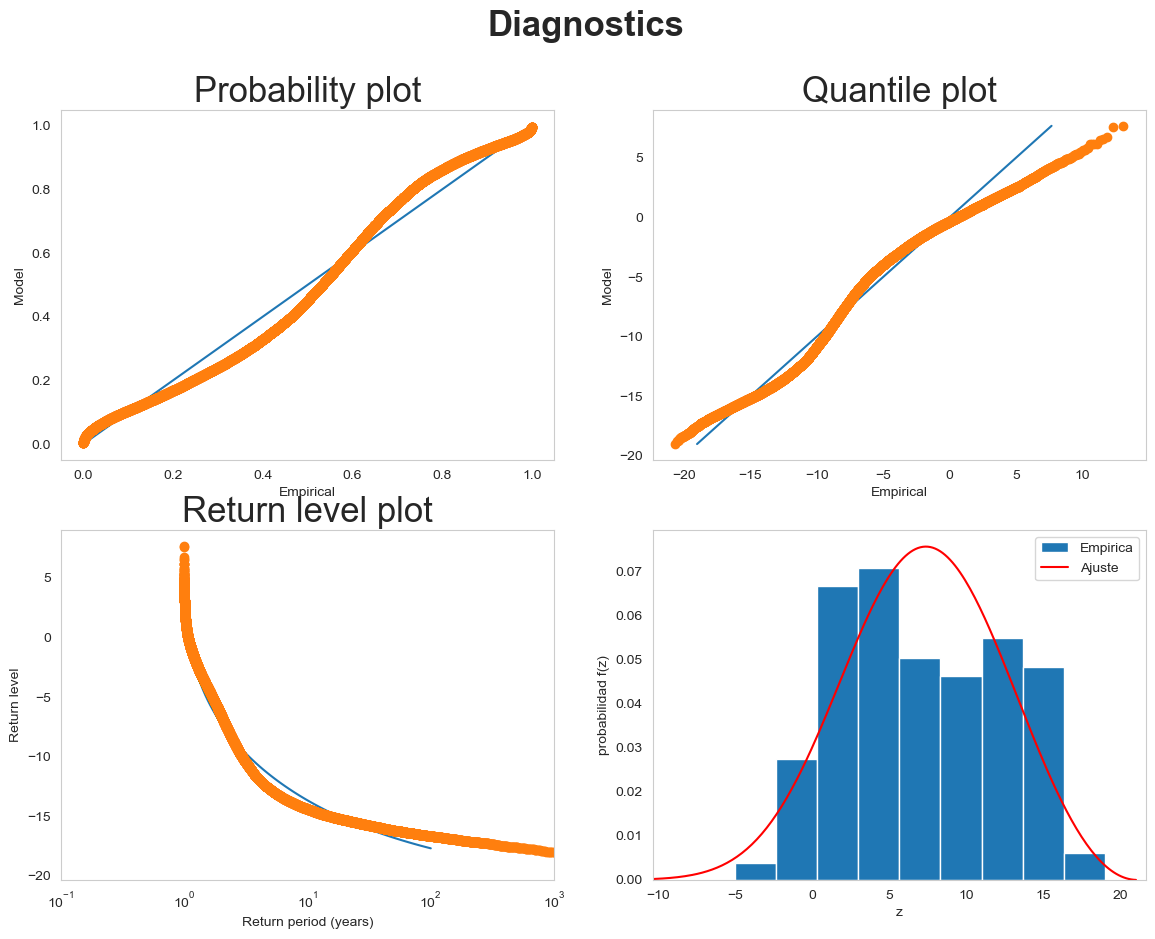

In [23]:
# import scipy.stats as stats
x = temp_min_mean.copy()
c, m, s = stats.genextreme.fit(x)
c = -c

print('MLE ='+'%.3f'%(MLE_GEV(c,m,s,x)))
print('c   = '+'%.3f'%(c))
print('m   = '+'%.3f'%(m))
print('s   = '+'%.3f'%(s))
print('100 yr return value = '+'%.3f'%(returnLevel(0.01,c,m,s)))
diagnosticsGEV(x,c,m,s)

c=-0.148
m=-0.568
s=1.585
u=-0.568
100yr-return value=-2.489


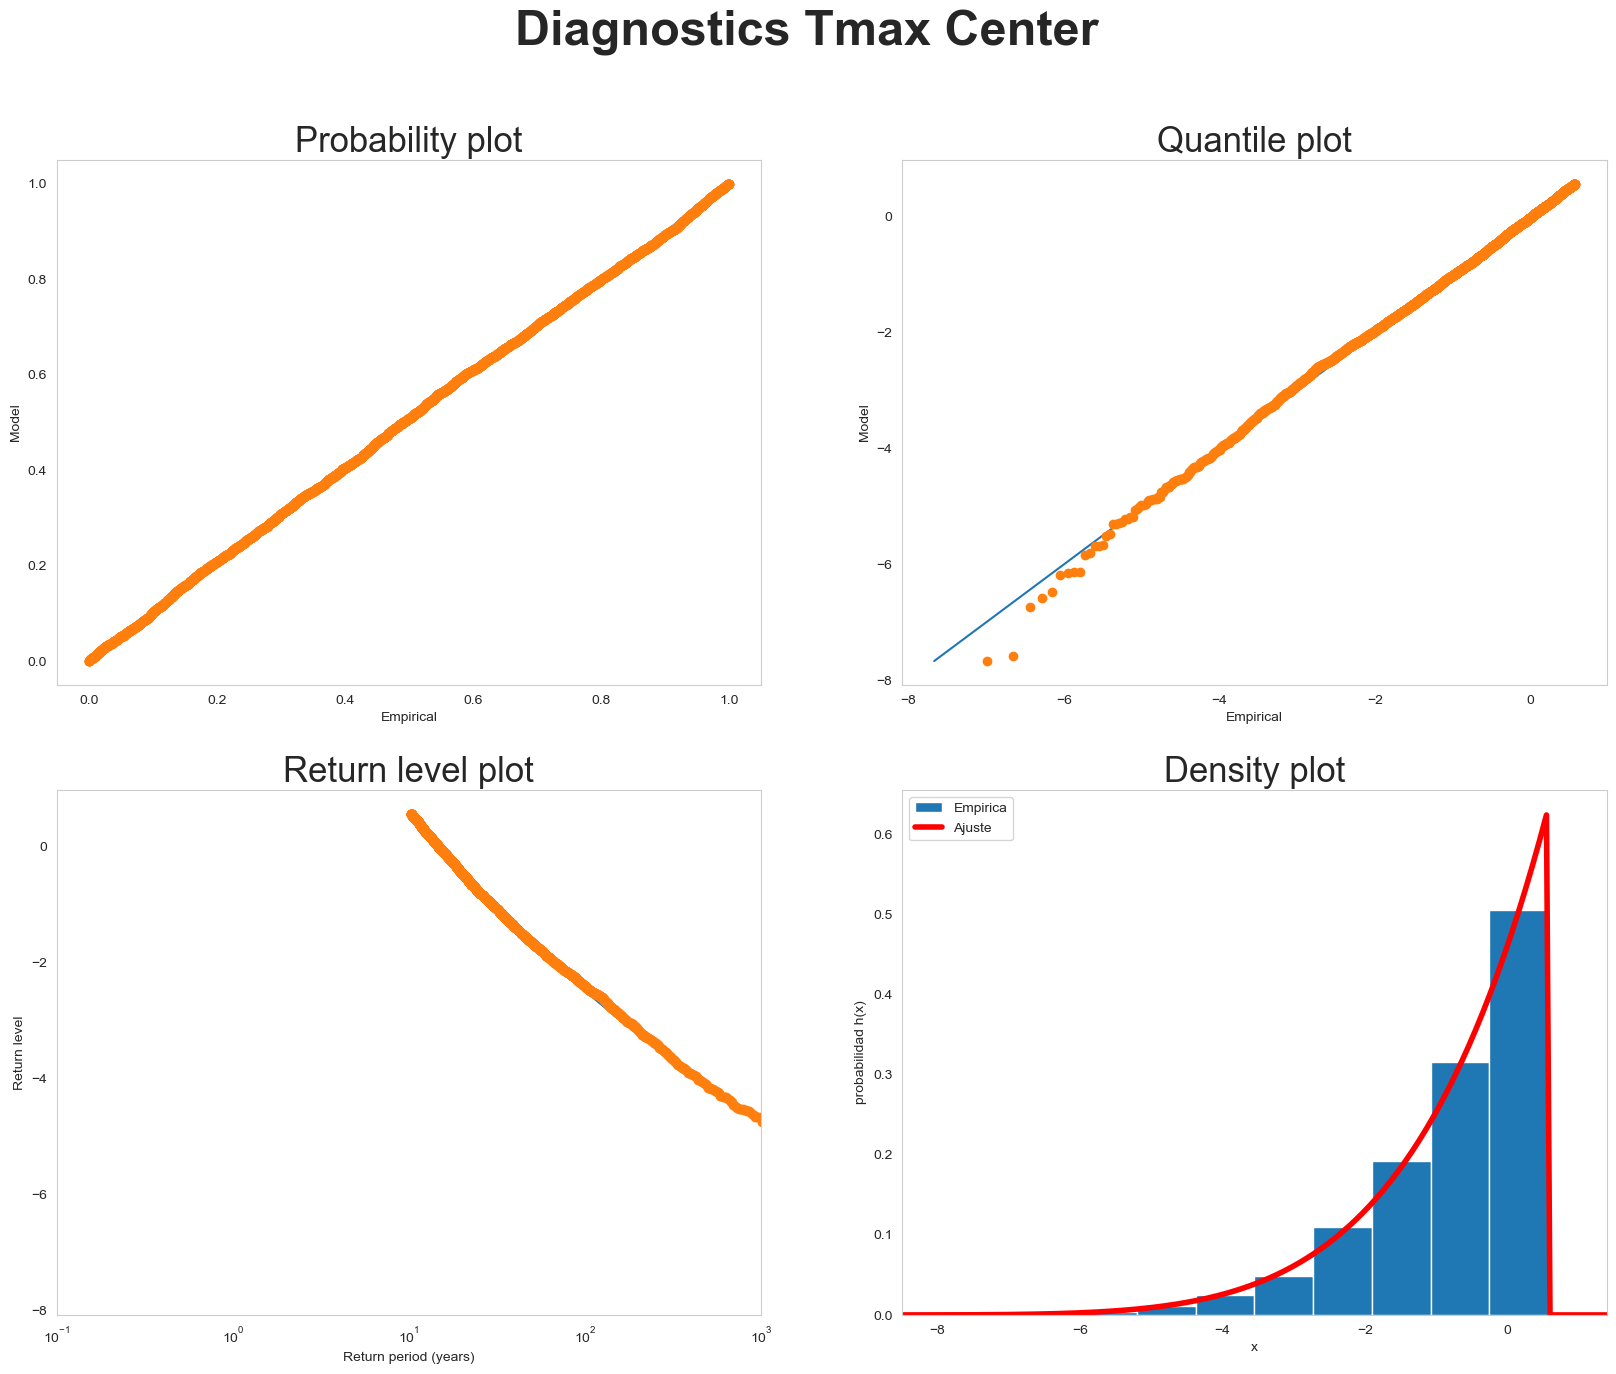

In [26]:
# Extremos por umbral
#==============================================================
#Seleccion del umbral: cogeremos el percentil 95
x=-temp_min_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.9]
u= xLess[-1] +.05
yExt = x[x>u].copy()  

#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100;
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
fig,ax=diagnosticsGPD(yExt,c,m,s,numYears,True)
fig.suptitle('Diagnostics Tmax Center',weight='bold',fontsize=35)
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))
print('u='+'%.3f'%(u))
print('100yr-return value='+'%.3f'%(-zp))

#### <span style='color:black'>Cold Days</span>

In [27]:
# open data
percent_cold_days_N = xr.open_dataarray(f'{folder}percent_cold_days_N.nc')
temp_max              = xr.open_dataset(f'{folder}tmax_pen.nc')

# media
temp_max_mean = temp_max.mean(dim=['lat', 'lon']).tx

MLE = 141485.469
c   = -0.243
m   = 15.650
s   = 6.985
100 yr return value = 34.982


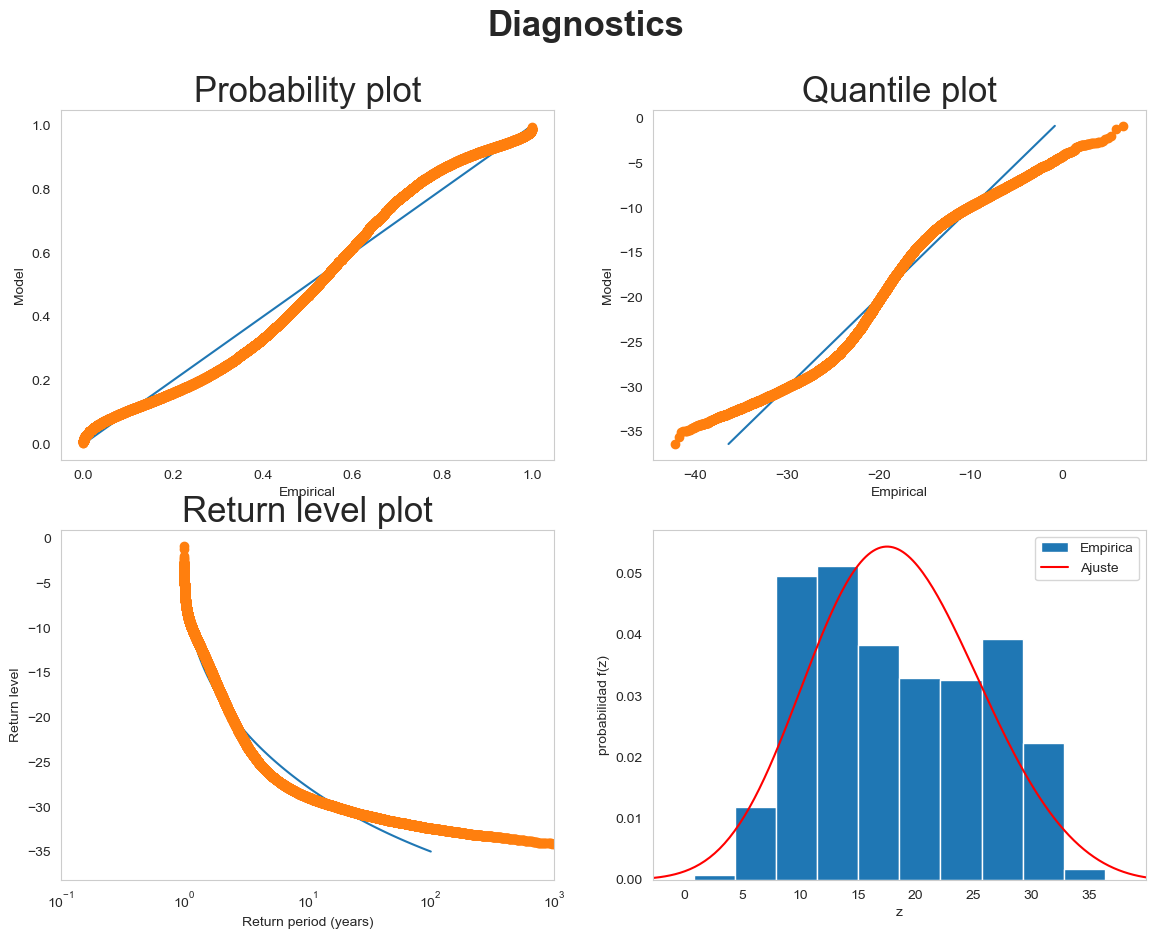

In [28]:
# import scipy.stats as stats
x = temp_max_mean.copy()
c, m, s = stats.genextreme.fit(x)
c = -c

print('MLE = '+'%.3f'%(MLE_GEV(c,m,s,x)))
print('c   = '+'%.3f'%(c))
print('m   = '+'%.3f'%(m))
print('s   = '+'%.3f'%(s))
print('100 yr return value = '+'%.3f'%(returnLevel(0.01,c,m,s)))
diagnosticsGEV(x,c,m,s)

c = -0.197
m = -9.319
s = 1.957
u = -9.319
100yr-return value = -5.724


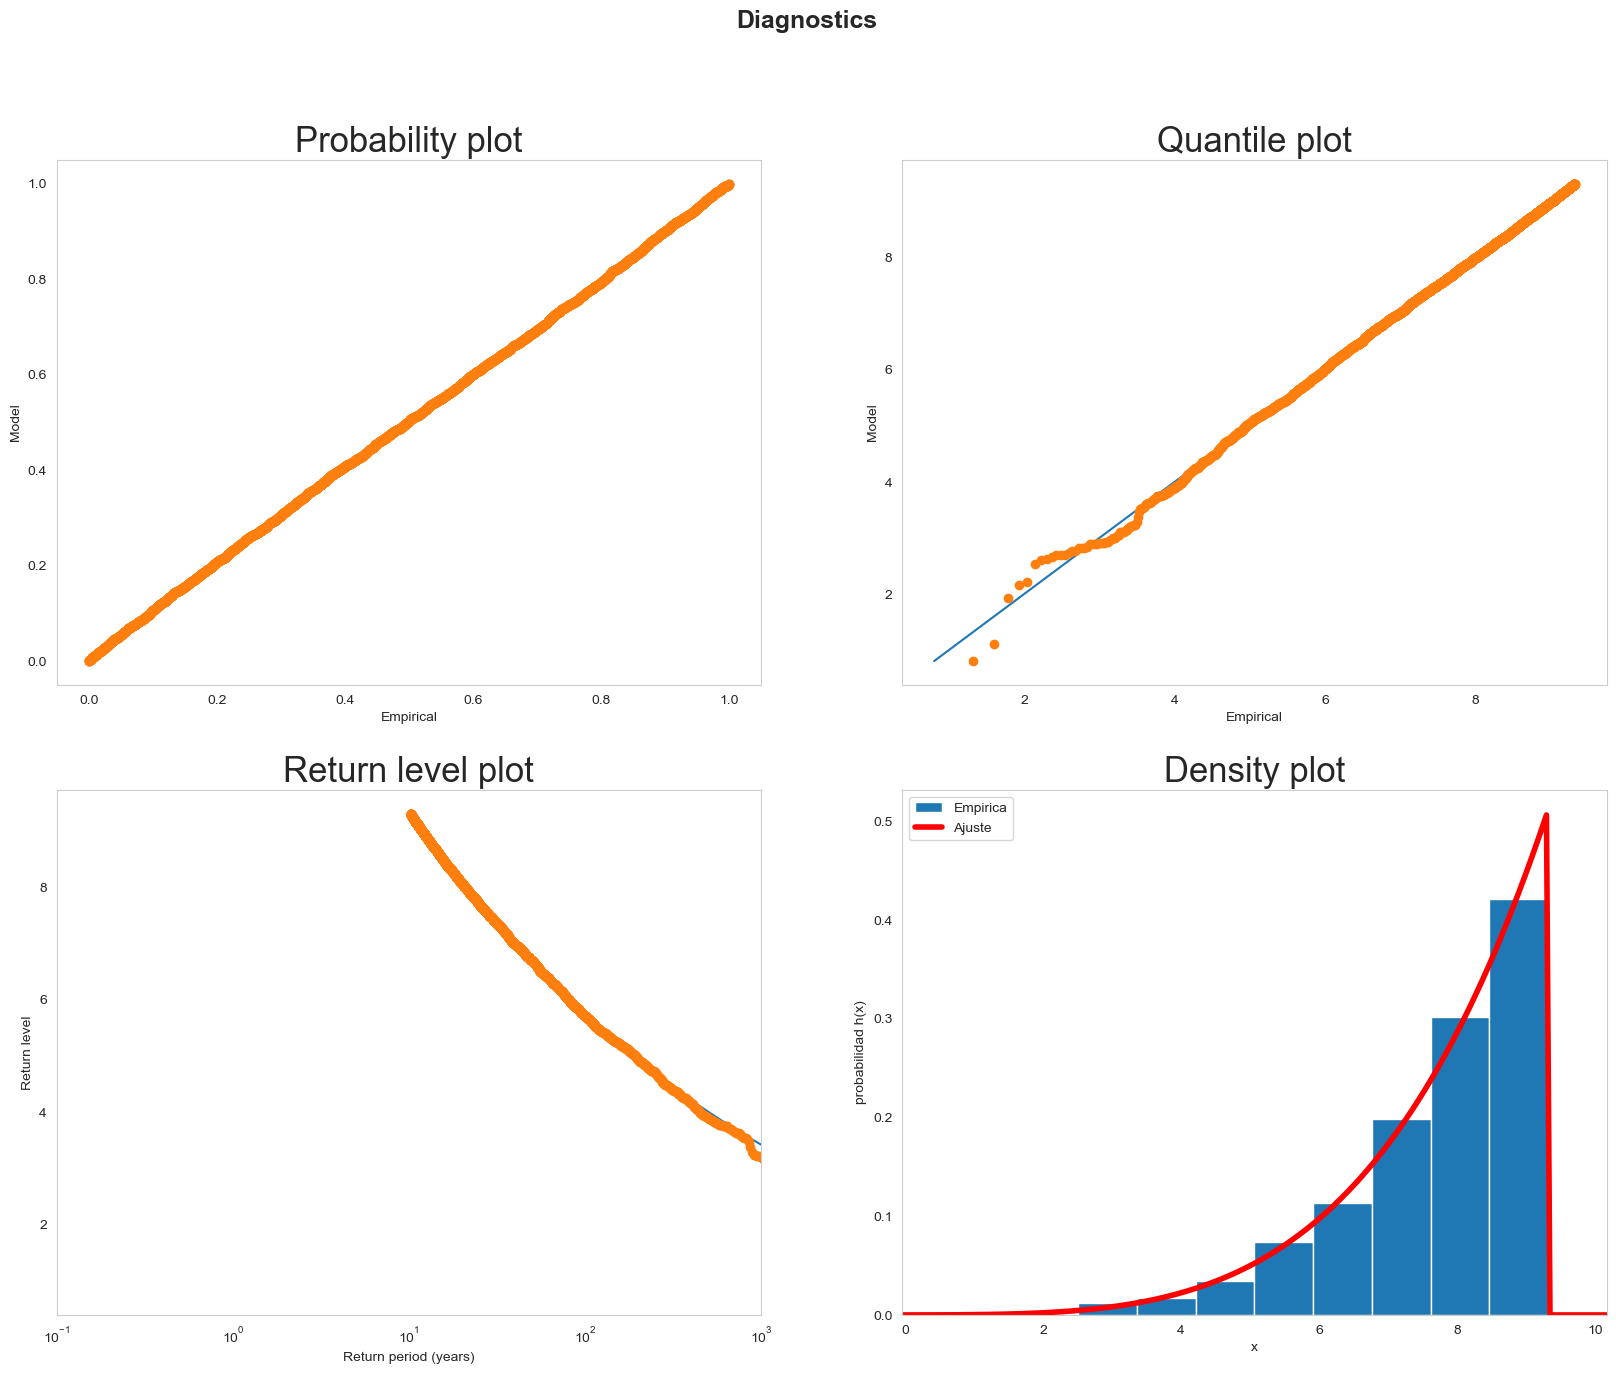

In [29]:
# Extremos por umbral
#==============================================================
#Seleccion del umbral: cogeremos el percentil 95
x = -temp_max_mean.copy()
xSort = np.sort(x)
pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
xLess= xSort[pExp<=.90]
u = xLess[-1] +.05
yExt = x[x>u].copy()  
#Ajuste usando herramienta de scipy:
c, m, s = stats.genpareto.fit(yExt,floc = u)

numYears=x.size
N = 100
fac = yExt.size/numYears
rv = stats.genpareto(c,m,s)
zp = rv.ppf(1-1/N/fac)

#Diagnóstico:
diagnosticsGPD(yExt,c,m,s,numYears)
print('c = '+'%.3f'%(c))
print('m = '+'%.3f'%(m))
print('s = '+'%.3f'%(s))
print('u = '+'%.3f'%(u))
print('100yr-return value = '+'%.3f'%(zp))

## <span style="color:green"> Objetivo 2: Análisis de las periodicidades fundamentales de los extremos</span>

In [142]:
def correct_series(percent, tmin, freq='YS'):
    '''
    El objetivo de esta función es volver a colocar los np.nan en las posiciones del cuadrado de lat y lon donde 
    no tenemos datos. Al calcular el índice de extremos esos puntos han quedado con 0. Esto hace que al promediar esas
    dimensiones infraestimemos la media
    '''

    # tmin = tmin.rename({'Time': 'time'})
    if freq=='YS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=((tminR.time.dt.month == 6) & (tminR.time.dt.day == 1)))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'time': percent.time, 'y': percent.lat,'x': percent.lon},dims=['time','lat','lon'])
        result = corr_R_x.mean(dim=['lon','lat'])


    if freq=='MS':
        tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),time=slice(str(int(np.min(percent.time.dt.year))),str(int(np.max(percent.time.dt.year)))))
        tminR_year = tminR.sel(time=(tminR.time.dt.day == 10))
        corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
        corr_R_x = xr.DataArray(corr_R,coords={'y': percent.lat, 'x': percent.lon,'time': percent.time},dims=['lat','lon','time'])

        result = corr_R_x.mean(dim=['lat','lon'])

    return result

In [31]:
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

In [32]:
corr_N, tminR = correct_series_no(percent = percent_cold_nights_N, tmin=temp_min.tn)
corr_N_days, tminR = correct_series_no(percent = percent_cold_days_N, tmin=temp_max.tx)

In [33]:
# datos que voy a utilizar
x      = corr_N
x_days = corr_N_days

# cálculo de los espectros para las noches frias
fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)

# cálculo de los espectros para los días fríos
fa_days, Ga_days = espectroArmonico(x_days,1)
ff_days, Gf_days = espectroFFT(x_days,1)

La varianza de la serie original, es  14.984223638773598
La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es  14.991619024636313 14.991619024636313


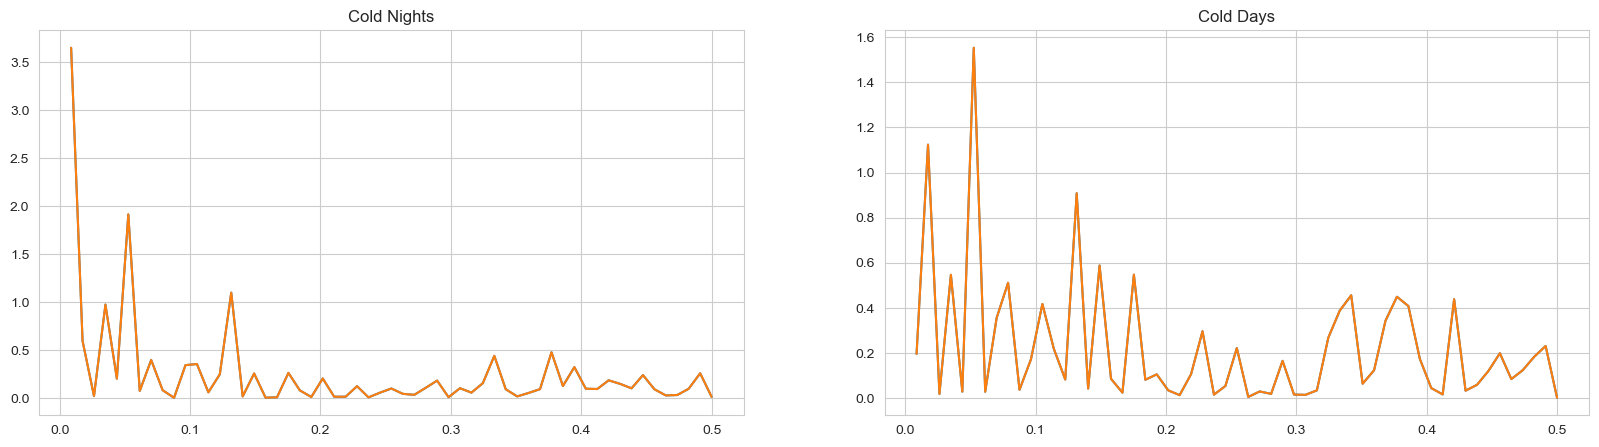

In [34]:
# Prueba de como hacerlo
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
axes[0].plot(fa,Ga)
axes[0].plot(ff,Gf)
axes[0].set_title('Cold Nights')

axes[1].plot(fa_days,Ga_days)
axes[1].plot(ff_days,Gf_days)
axes[1].set_title('Cold Days')

print('La varianza de la serie original, es ',np.var(x))
print('La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es ',
        np.sum(Ga),np.sum(Gf))

Tenemos aquí un periodograma de dos índices de extremos para la zona norte. Destaca una frecuencia notable en el índice de cold nights.

La varianza de la serie es  0.9999999999999999
La integral del espectro es  1.0004935448135988
La varianza de la serie es  0.9999999999999998
La integral del espectro es  1.0000530759506527


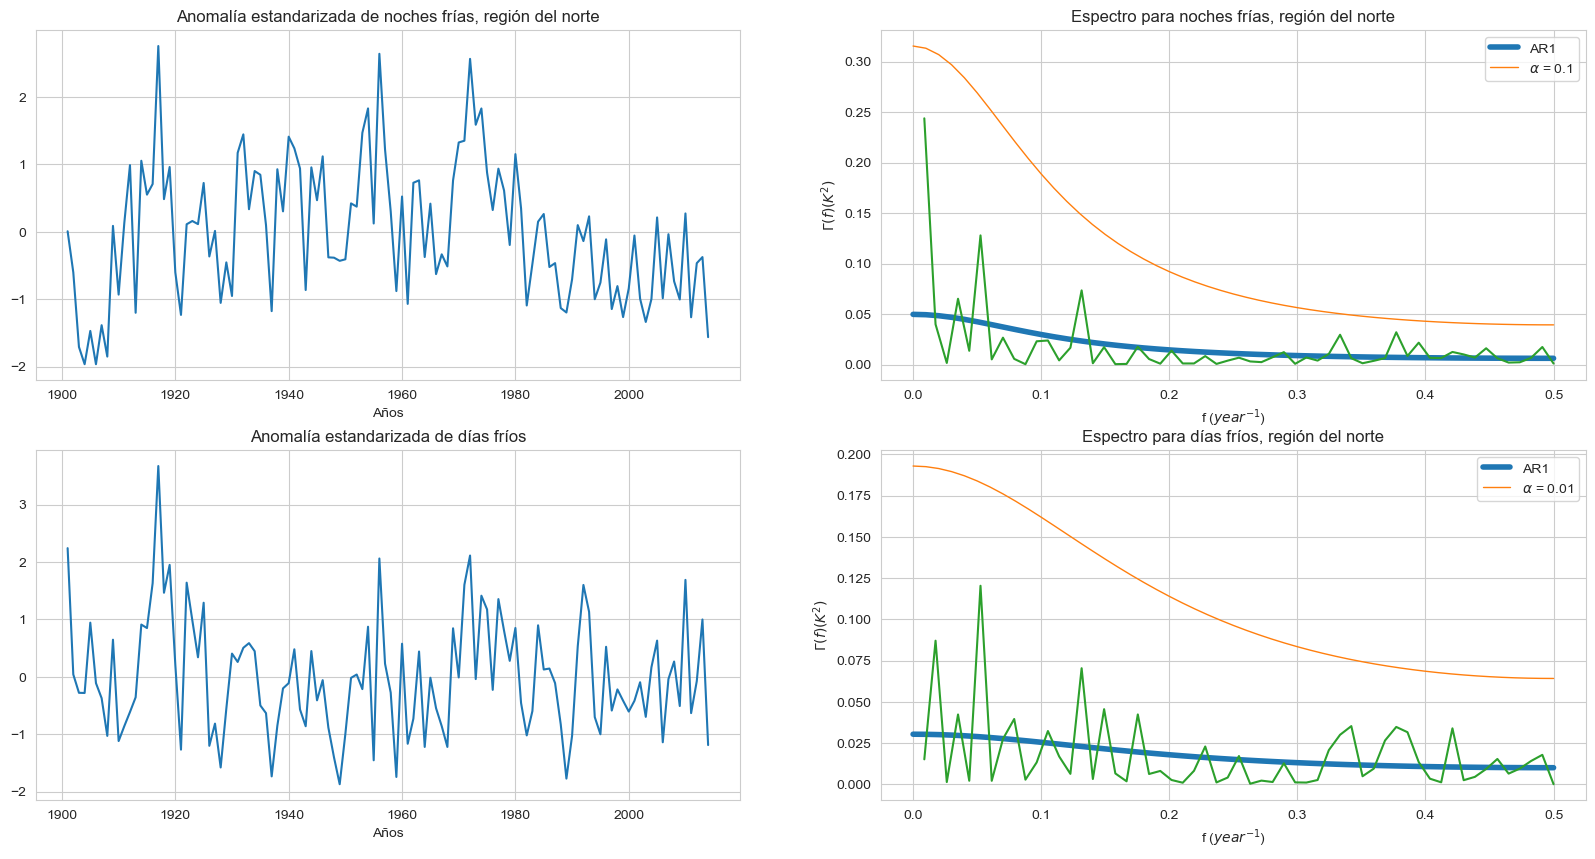

In [35]:
fig,ax = plt.subplots(2, 2, figsize=(20,10))
años   = np.arange(1901, 2014+1)

# Cold days
anomalia_std_noches_frias=(x-np.mean(x))/np.std(x)

ax[0,0].plot(años, anomalia_std_noches_frias)
ax[0,0].set_title('Anomalía estandarizada de noches frías, región del norte')
ax[0,0].set_xlabel(u'Años')

x = np.squeeze(np.array(anomalia_std_noches_frias))
#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS, 2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[0,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[0,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = '+str(alpha))
a,s2,chi2
ax[0,1].legend()
ff,Gf = espectroFFT(x,1)
ax[0,1].plot(ff,Gf,label='fft')
ax[0,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[0,1].set_xlabel(r'f ($year^{-1}$)')
ax[0,1].set_title('Espectro para noches frías, región del norte')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


# Cold days
anomalia_std_dias_frios = (x_days-np.mean(x_days))/np.std(x_days)
ax[1,0].plot(años, anomalia_std_dias_frios)
ax[1,0].set_title('Anomalía estandarizada de días fríos')
ax[1,0].set_xlabel(u'Años')

x = np.squeeze(np.array(anomalia_std_dias_frios))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1,1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1,1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.01')
a,s2,chi2
ax[1,1].legend()
ff,Gf = espectroFFT(x,1)
ax[1,1].plot(ff,Gf,label='fft')
ax[1,1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1,1].set_xlabel(r'f ($year^{-1}$)')
ax[1,1].set_title('Espectro para días fríos, región del norte')

print('La varianza de la serie es ',  np.var(x))
print('La integral del espectro es ', sum(Gf))

In [126]:
tmin = temp_min.tn
tmax = temp_max.tx

In [128]:
#  Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per,freq='MS')
    percent_cold_nights = num_cold/num_cold.time.dt.days_in_month * 100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmax.sel(time=slice(period[0],period[1])), tmax_per,freq='MS')
    percent_cold_days = num_cold/num_cold.time.dt.days_in_month * 100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days

In [129]:
tmin_p10_N, percent_cold_nights_N_m = cold_nights_xclim(temp_min.tn.sel(lat=slice(lats[0], lats[1]), lon=slice(longs[0], longs[1])),['1901', '2014'])
tmax_p10_N, percent_cold_days_N_m   = cold_days_xclim(temp_max.tx.sel(lat=slice(lats[0], lats[1]), lon=slice(longs[0], longs[1])),
                                                    ['1901', '2014'])

Te he cambiado el tiempo
>> Calculando percentiles
>> Percentiles calculados
>> Calculando indice
>> Índice calculado
>> Calculando percentiles
>> Percentiles calculados
>> Calculando indice
>> Índice calculado


In [130]:
# corrijo las series como hemos hecho antes
temp_min_rename = temp_min.rename({'Time': 'time'})
temp_max_rename = temp_max.rename({'Time': 'time'})

In [ ]:
# cambio las dimensiones porque me da error
temp_min_rename = temp_min_rename.to_array().squeeze().transpose('lat','lon','time')
temp_max_rename = temp_max_rename.to_array().squeeze().transpose('lat','lon','time')

In [143]:
# cálculo del porcentaje
# percent_cold_nights_N_m = num_cold_nights_N_m/(num_cold_nights_N_m.time.dt.days_in_month)*100
# percent_cold_days_N_m   = num_cold_days_N_m/(num_cold_days_N_m.time.dt.days_in_month)*100

corr_N_monthly_nights = correct_series(percent_cold_nights_N_m, tmin=temp_min_rename, freq='MS')
corrN_monthly_days    = correct_series(percent_cold_days_N_m,   tmin=temp_max_rename, freq='MS')

In [153]:
# cálculo de las anomalías
anom_N     = (corr_N_monthly_nights.groupby('time.month')-corr_N_monthly_nights.groupby('time.month').mean('time'))#/(corr_O_monthly.groupby('time.month').std('time'))
anom_N_std = anom_N.groupby('time.month')/corr_N_monthly_nights.groupby('time.month').std('time')

anom_N_days     = (corrN_monthly_days.groupby('time.month') - corrN_monthly_days.groupby('time.month').mean('time'))
anom_N_std_days = anom_N_days.groupby('time.month')/corrN_monthly_days.groupby('time.month').std('time')

La varianza de la serie es  1.0000000000000002
La integral del espectro es  0.9999999999999999
La varianza de la serie es  0.9999999999999986
La integral del espectro es  0.9999999999999999


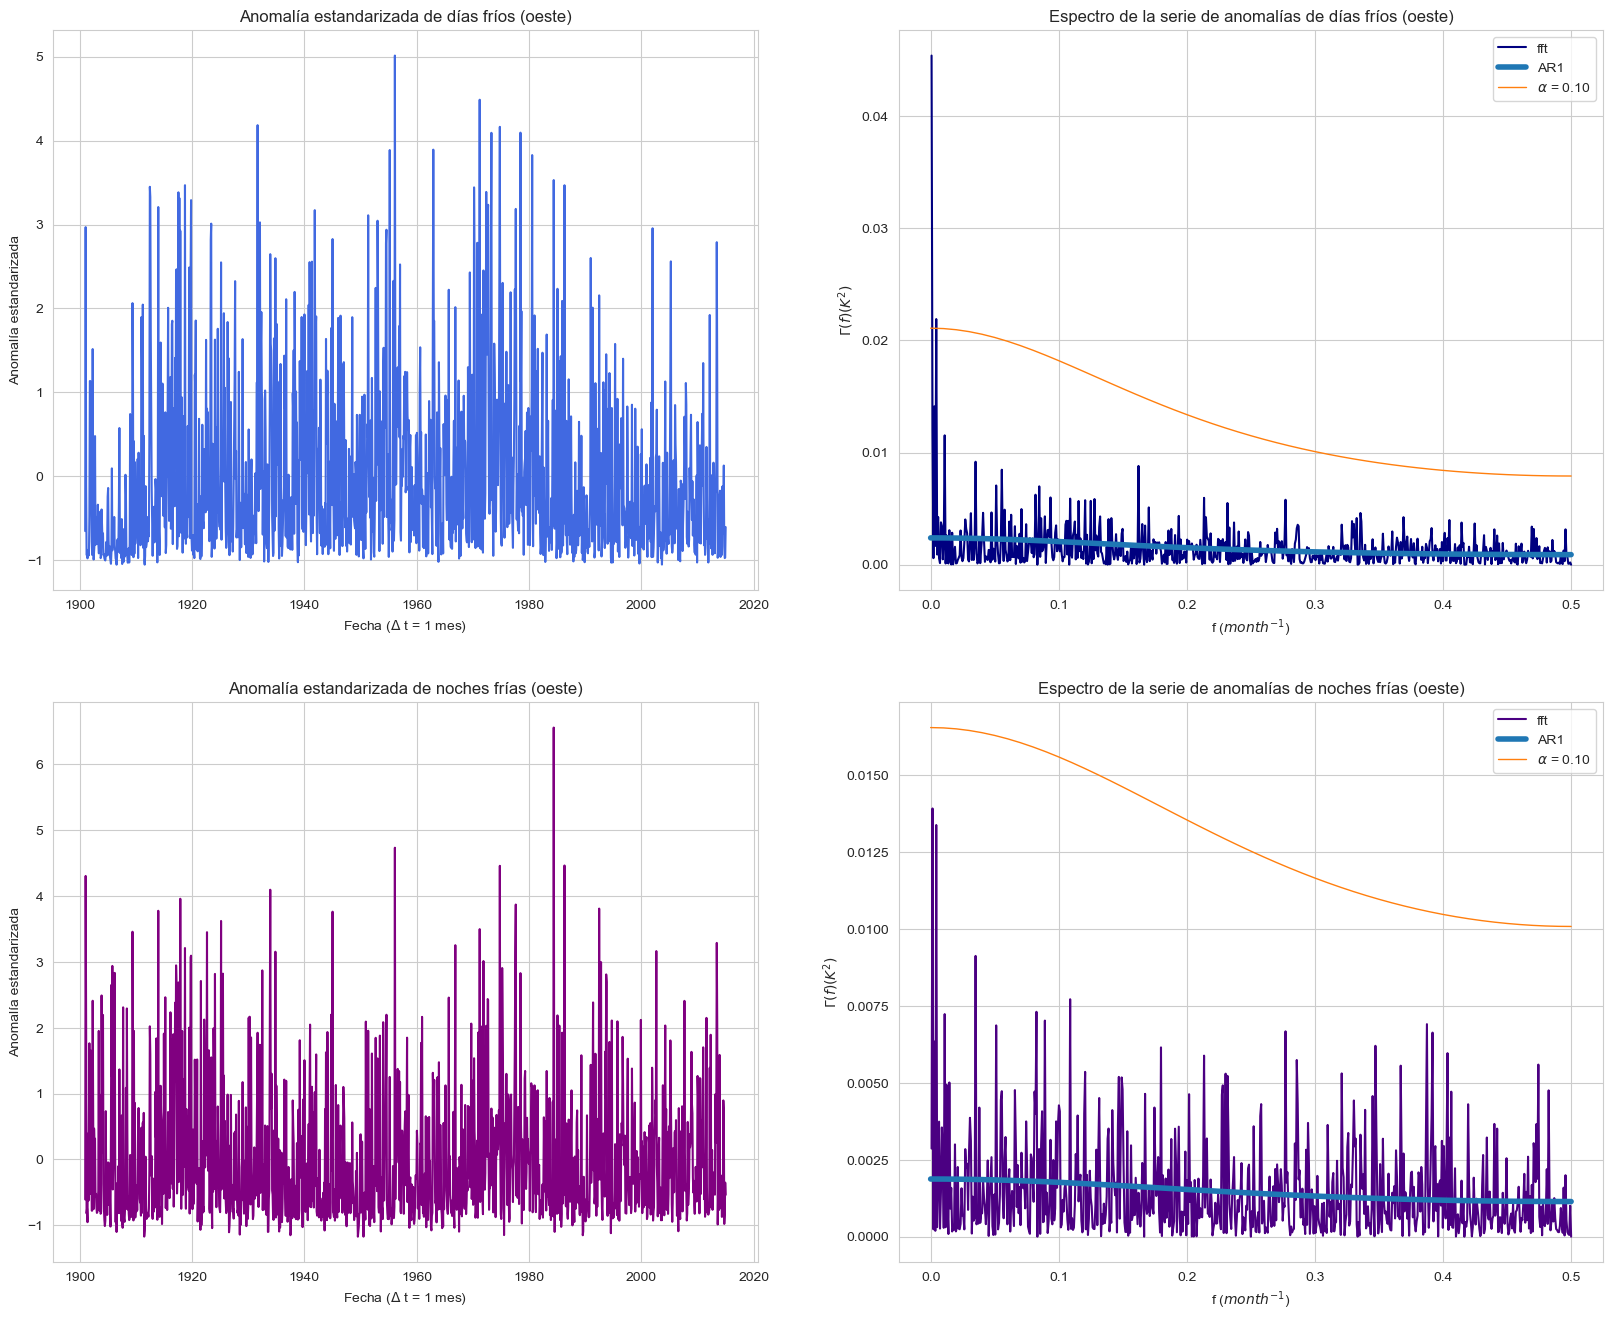

In [154]:
# VAMOS A HACERLO POR MESES
fig,(ax,axd)=plt.subplots(2,2,figsize=(20,16))
años = np.linspace(1901,2015,1368)
x = anom_N_std
ax[0].plot(años,x,color='royalblue')
ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
ax[0].set_title(u'Anomalía estandarizada de días fríos (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro de la serie de anomalías de días fríos (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


x = anom_N_std_days
axd[0].plot(años,x,color='purple')
axd[0].set_ylabel(u'Anomalía estandarizada')
axd[0].set_xlabel(r'Fecha ($\Delta$ t = 1 mes)')
axd[0].set_title(u'Anomalía estandarizada de noches frías (oeste)')


#fa,Ga = espectroArmonico(x,1)
ff_days,Gf_days = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
axd[1].plot(ff_days,Gf_days,label='fft',color='indigo')
axd[1].set_ylabel(r'$\Gamma(f) (K^2)$')
axd[1].set_xlabel(r'f ($month^{-1}$)')
axd[1].set_title('Espectro de la serie de anomalías de noches frías (oeste)')

print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf_days.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
axd[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
axd[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
axd[1].legend()

In [156]:
# picos que sobrepasan
x0 = np.where(Gf>0.02)
cortes = ff[x0]
print(f'Frecuencias de los picos de noches frías {ff[x0]}')

Frecuencias de los picos de noches frías [0.00073099 0.00438596]


### <span style='color:darkblue'> Filtros </span>

#### <span style='color:black'> Cold Nights </span>

fc 0.0045


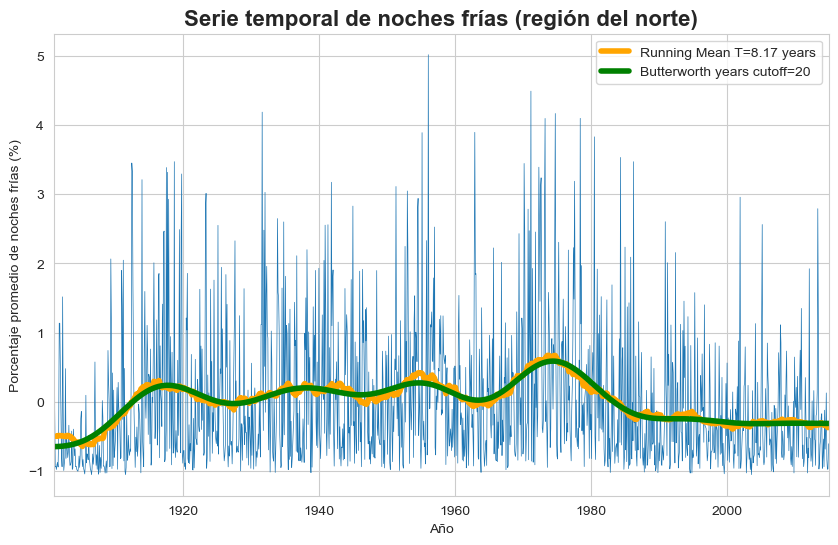

In [161]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

# La señal inicial
x = np.squeeze(np.array(anom_N_std))
t = np.squeeze(np.linspace(1901, 2015,1368))
N = x.size


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte(40 años):
fc = 0.0045
print('fc',fc)
#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)
#Window = Tc

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,fc*2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
ytot_but = signal.filtfilt(b,a,xtot)
yButter = ytot_but[N:2*N]
ax.plot(t, x, linewidth=0.5)
ax.set_title('Serie temporal de noches frías (región del norte)',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.plot(t,yRunningMean,linewidth= 4,color='orange',label=f'Running Mean T={np.round(Window/12, 2)} years')
ax.plot(t,yButter,linewidth= 4,color='green',label='Butterworth years cutoff='+str(nyc))
ax.set_xlim([1901,2015])
ax.legend()

La varianza de la serie es  4.105413216078112
La integral del espectro es  4.1054235521132085


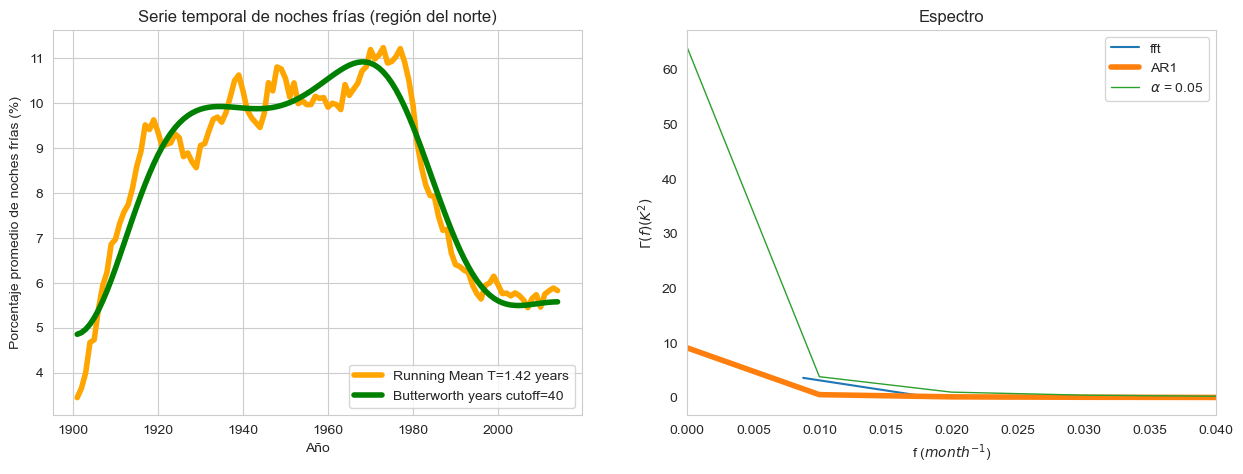

In [47]:
# todo junto
fig,ax = plt.subplots(1,2,figsize=(15,5))
eje_x  = np.arange(1,yButter.size+1)

ax[0].plot(t,yRunningMean,linewidth= 4,color='orange',label=f'Running Mean T={np.round(Window/12, 2)} years')
ax[0].plot(t,yButter,linewidth= 4,color='green',label='Butterworth years cutoff='+str(nyc))
ax[0].set_title('Serie temporal e noches frías para la región del norte')
ax[0].set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax[0].set_xlabel(u'Año')
ax[0].set_title('Serie temporal de noches frías (región del norte)')
ax[0].legend()

x = np.squeeze(np.array(yButter))

#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft')
ax[1].grid()
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1].set_xlim(0,0.04)
ax[1].legend()

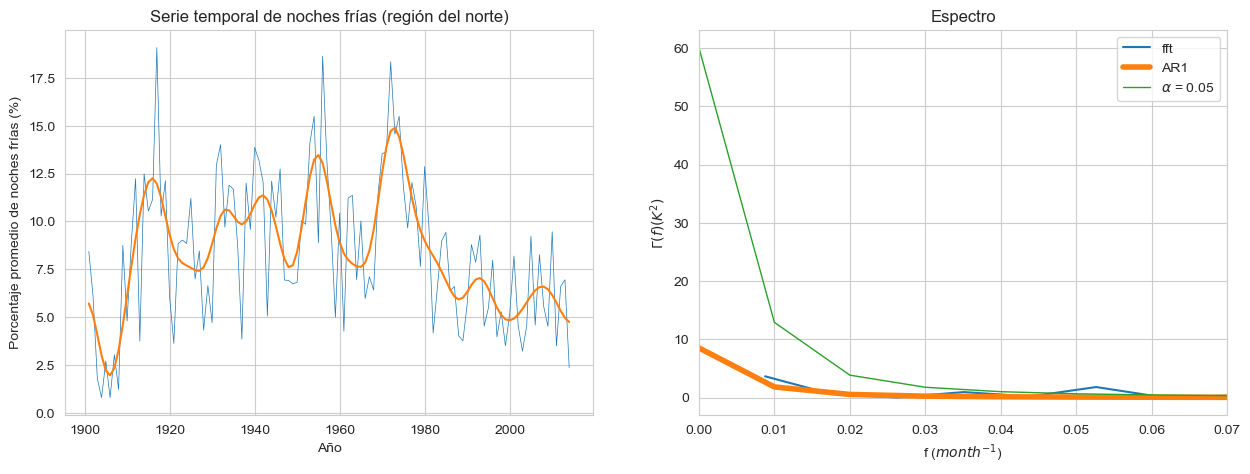

In [48]:
n = 4
b,a = signal.butter(n,0.2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
x = np.squeeze(np.array(corr_N))
ytot = signal.filtfilt(b,a,xtot)
filtedData = ytot[N:2*N]
fig,ax=plt.subplots(1,2,figsize=(15,5))
eje_x=np.arange(1,filtedData.size+1)
ax[0].plot(t,x,linewidth=0.5)
ax[0].plot(t,filtedData)
ax[0].set_title('Serie temporal e noches frías para la región del norte')
ax[0].set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax[0].set_xlabel(u'Año')
ax[0].set_title('Serie temporal de noches frías (región del norte)')
x = np.squeeze(np.array(filtedData))

#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1].set_xlim(0,0.07)
ax[1].legend()

#### <span style='color:black'> Cold Days </span>

fc 0.05


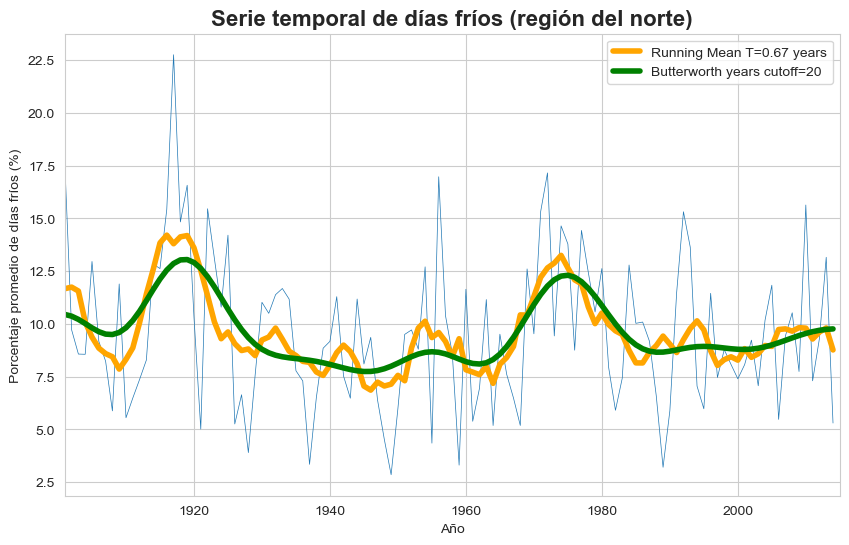

In [49]:
# lo mismo para cold days
fig,ax = plt.subplots(1,1,figsize=(10,6))

# La señal inicial
x = np.squeeze(np.array(corr_N_days))
t = np.squeeze(np.arange(1901, 2015))
N = x.size


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte(40 años):
nyc = 20
Tc = nyc 
fc = 1 / Tc
print('fc',fc)
#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)
#Window = Tc

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,fc*2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]
ax.plot(t,x,linewidth=0.5)
ax.set_title('Serie temporal de días fríos (región del norte)',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.plot(t,yRunningMean,linewidth= 4,color='orange',label=f'Running Mean T={np.round(Window/12, 2)} years')
ax.plot(t,yButter,linewidth= 4,color='green',label='Butterworth years cutoff='+str(nyc))
ax.set_xlim([1901,2015])
ax.legend()

La varianza de la serie es  2.023459974025145
La integral del espectro es  2.023469469301447


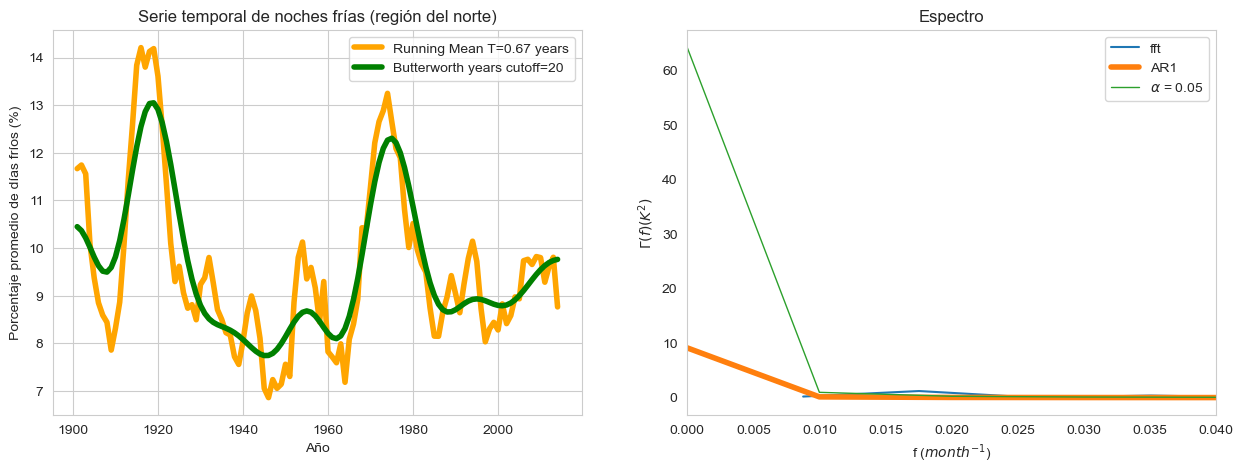

In [50]:
# todo junto
fig,ax = plt.subplots(1,2,figsize=(15,5))
eje_x  = np.arange(1,yButter.size+1)

ax[0].plot(t,yRunningMean,linewidth= 4,color='orange', label=f'Running Mean T={np.round(Window/12, 2)} years')
ax[0].plot(t,yButter,linewidth= 4,color='green',label='Butterworth years cutoff='+str(nyc))
ax[0].set_title('Serie temporal de días fríos para la región del norte')
ax[0].set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax[0].set_xlabel(u'Año')
ax[0].set_title('Serie temporal de noches frías (región del norte)')
ax[0].legend()

x = np.squeeze(np.array(yButter))

#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft')
ax[1].grid()
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1].set_xlim(0,0.04)
ax[1].legend()

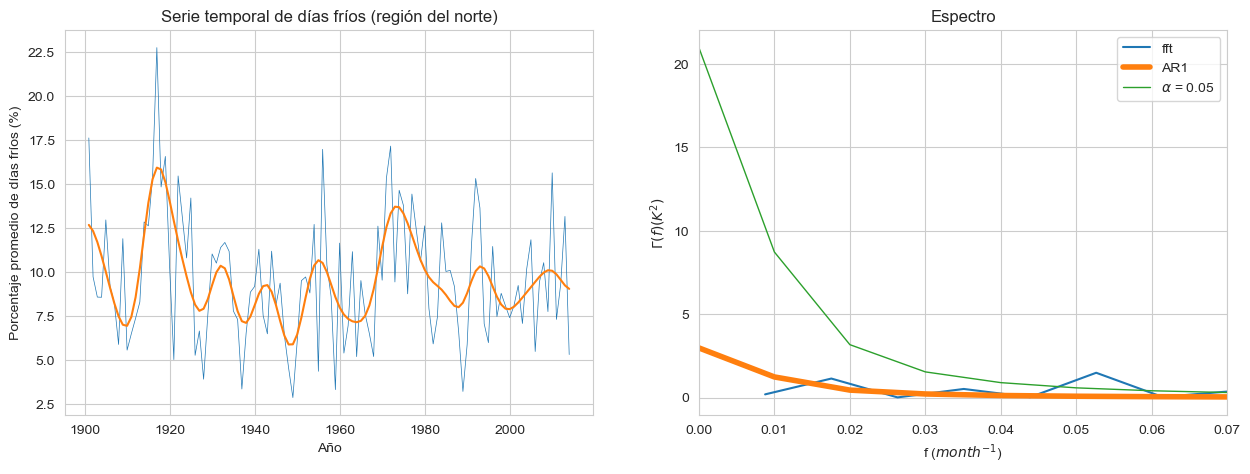

In [51]:
n = 4
b,a = signal.butter(n,0.2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
x = np.squeeze(np.array(corr_N_days))
ytot = signal.filtfilt(b,a,xtot)
filtedData = ytot[N:2*N]
fig,ax=plt.subplots(1,2,figsize=(15,5))
eje_x=np.arange(1,filtedData.size+1)
ax[0].plot(t,x,linewidth=0.5)
ax[0].plot(t,filtedData)
ax[0].set_title('Serie temporal de días fríos para la región del norte')
ax[0].set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax[0].set_xlabel(u'Año')
ax[0].set_title('Serie temporal de días fríos (región del norte)')
x = np.squeeze(np.array(filtedData))

#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1].set_xlim(0,0.07)
ax[1].legend()